In [1728]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

In [1729]:
df = pd.read_csv("file3.csv")

In [1730]:
df.head()

Date       ETH     BTC       XRP   LTC       XLM  Palladium    Gold  \
0  2016-01-01  0.948024  434.33  0.005955  3.51  0.001748     562.00  1060.2   
1  2016-01-02  0.937124  433.44  0.006065  3.50  0.001741     562.00  1060.2   
2  2016-01-03  0.971905  430.01  0.006017  3.48  0.001744     562.00  1060.2   
3  2016-01-04  0.954480  433.09  0.005958  3.50  0.001748     544.20  1075.2   
4  2016-01-05  0.950176  431.96  0.006044  3.47  0.001721     535.75  1078.4   

           HSI        N225   SP500  NVIDIA   AMD  
0  2810.900488  174.137258  2035.4   32.96  2.87  
1  2810.900488  174.137258  2035.4   32.96  2.87  
2  2810.900488  174.137258  2035.4   32.96  2.87  
3  2735.571521  168.805923  2009.1   32.37  2.77  
4  2717.819530  168.101637  2011.7   32.89  2.75

In [1731]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1827 non-null   object 
 1   ETH        1827 non-null   float64
 2   BTC        1827 non-null   float64
 3   XRP        1827 non-null   float64
 4   LTC        1827 non-null   float64
 5   XLM        1827 non-null   float64
 6   Palladium  1827 non-null   float64
 7   Gold       1827 non-null   float64
 8   HSI        1827 non-null   float64
 9   N225       1827 non-null   float64
 10  SP500      1827 non-null   float64
 11  NVIDIA     1827 non-null   float64
 12  AMD        1827 non-null   float64
dtypes: float64(12), object(1)
memory usage: 185.7+ KB


In [1732]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [1733]:
df.set_index('Date', inplace=True)

In [1734]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ETH        1827 non-null   float64
 1   BTC        1827 non-null   float64
 2   XRP        1827 non-null   float64
 3   LTC        1827 non-null   float64
 4   XLM        1827 non-null   float64
 5   Palladium  1827 non-null   float64
 6   Gold       1827 non-null   float64
 7   HSI        1827 non-null   float64
 8   N225       1827 non-null   float64
 9   SP500      1827 non-null   float64
 10  NVIDIA     1827 non-null   float64
 11  AMD        1827 non-null   float64
dtypes: float64(12)
memory usage: 185.6 KB


In [1735]:
df.head(3)

ETH     BTC       XRP   LTC       XLM  Palladium    Gold  \
Date                                                                        
2016-01-01  0.948024  434.33  0.005955  3.51  0.001748      562.0  1060.2   
2016-01-02  0.937124  433.44  0.006065  3.50  0.001741      562.0  1060.2   
2016-01-03  0.971905  430.01  0.006017  3.48  0.001744      562.0  1060.2   

                    HSI        N225   SP500  NVIDIA   AMD  
Date                                                       
2016-01-01  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-02  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-03  2810.900488  174.137258  2035.4   32.96  2.87

## Model

Puoi scegliere fino a quando guardare in avanti con la previsione

In [1736]:
nrows = df.shape[0]
np_data = np.reshape(np.array(df), (nrows, -1))

In [1737]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data = scaler.fit_transform(np_data)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['BTC'])
np_BTC_scaled = scaler_pred.fit_transform(df_Close)

In [1738]:
type(np_data)

numpy.ndarray

In [1739]:
np_data.shape

(1827, 12)

In [1740]:
np_data[0]

array([7.81091634e-06, 2.44435684e-03, 2.49786067e-04, 1.43524512e-03,
       3.39747179e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
       3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02])

In [1741]:
type(np_data)

numpy.ndarray

In [1742]:
index = df.columns.get_loc("BTC")
index

1

In [1743]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1 # = number of neurons in the first layer of the neural network

# Prediction Index

index_Close = index

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [1744]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end,index_Close]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
n_past = 1
n_future = 1


In [1745]:
# Generate training data and test data
x_train, y_train = split_series(train_data,n_past, n_future)
x_test, y_test = split_series(test_data,n_past, n_future)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][n_past-1][index_Close])
print(y_train[0])

(1644, 1, 12) (1644, 1)
(182, 1, 12) (182, 1)
0.0024132785843961335
[0.00241328]


In [1746]:
x_train[0:6]

array([[[7.81091634e-06, 2.44435684e-03, 2.49786067e-04, 1.43524512e-03,
         3.39747179e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[0.00000000e+00, 2.41327858e-03, 2.82379741e-04, 1.40710306e-03,
         3.31924053e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[2.49239891e-05, 2.29350510e-03, 2.68157047e-04, 1.35081893e-03,
         3.35276821e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[1.24372719e-05, 2.40105680e-03, 2.50674985e-04, 1.40710306e-03,
         3.39747179e-04, 3.31861368e-02, 1.48632580e-02, 2.02738936e-01,
         2.77340254e-01, 9.77598898e-02, 1.28306356e-02, 1.01762484e-02]],

       [[9.35303487e-06, 2.36159790e-03, 2.76157312e-04, 1.32267687e-03,
         3.09572265e-04, 2.94170124e-02

In [1747]:
#ti da come y i 5 dati futuri di BTC
y_train[0:6]

array([[0.00241328],
       [0.00229351],
       [0.00240106],
       [0.0023616 ],
       [0.00226208],
       [0.00327264]])

In [1748]:
x_train.shape, y_train.shape

((1644, 1, 12), (1644, 1))

In [1749]:
x_test.shape, y_test.shape

((182, 1, 12), (182, 1))

In [1750]:
len(x_train)

1644

In [1751]:
df.head(3)

ETH     BTC       XRP   LTC       XLM  Palladium    Gold  \
Date                                                                        
2016-01-01  0.948024  434.33  0.005955  3.51  0.001748      562.0  1060.2   
2016-01-02  0.937124  433.44  0.006065  3.50  0.001741      562.0  1060.2   
2016-01-03  0.971905  430.01  0.006017  3.48  0.001744      562.0  1060.2   

                    HSI        N225   SP500  NVIDIA   AMD  
Date                                                       
2016-01-01  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-02  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-03  2810.900488  174.137258  2035.4   32.96  2.87

In [1752]:
list1 = []
for i in range(y_train.shape[0]):
      list1.append(y_train[i][-1])
#print(i)        

In [1753]:
list2 = []
for i in range(len(y_test)):
      list2.append(y_test[i][-1])

In [1754]:
y_train = np.array(list1)

In [1755]:
y_train.shape[0]

1644

In [1756]:
y_train.shape

(1644,)

In [1757]:
y_test = np.array(list2)

In [1758]:
y_test.shape

(182,)

In [1759]:
#x_train[0:6]

In [1760]:
#y_train[0:6]

In [1761]:
x_train[1]

array([[0.00000000e+00, 2.41327858e-03, 2.82379741e-04, 1.40710306e-03,
        3.31924053e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
        3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]])

In [1762]:
y_train[1]

0.002293505099452151

## LSTM

In [1763]:
n_neurons = x_train.shape[1] * x_train.shape[2]

In [1764]:
n_neurons

12

In [1765]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
#     outL = Dense(1, activation='relu')
    outL = Dense(1)
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [1766]:
model = createModel(12,12, 8, 4, (x_train.shape[1], x_train.shape[2]))
model.fit(x_train, y_train, batch_size=12, epochs=10, validation_data = (x_test, y_test))

Train on 1644 samples, validate on 182 samples
Epoch 1/10
1644/1644 [==============================] - 9s 6ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 2/10
1644/1644 [==============================] - 1s 719us/step - loss: 7.7709e-04 - val_loss: 0.0016
Epoch 3/10
1644/1644 [==============================] - 1s 723us/step - loss: 3.3743e-04 - val_loss: 0.0010
Epoch 4/10
1644/1644 [==============================] - 1s 728us/step - loss: 2.9699e-04 - val_loss: 7.7718e-04
Epoch 5/10
1644/1644 [==============================] - 1s 736us/step - loss: 3.0355e-04 - val_loss: 0.0030
Epoch 6/10
1644/1644 [==============================] - 1s 730us/step - loss: 2.2909e-04 - val_loss: 0.0022
Epoch 7/10
1644/1644 [==============================] - 1s 737us/step - loss: 3.1521e-04 - val_loss: 0.0023
Epoch 8/10
1644/1644 [==============================] - 1s 722us/step - loss: 2.1519e-04 - val_loss: 0.0027
Epoch 9/10
1644/1644 [==============================] - 1s 706us/step - loss: 2.4062e-04 - 

In [1767]:
from sklearn.metrics import mean_squared_error as mse

In [1768]:
y_pred_train = model.predict(x_train)
mse(y_train, y_pred_train)

0.00029950252727663787

In [1769]:
y_pred = model.predict(x_test)
mse(y_test, y_pred)

0.003246705534806564

In [1770]:
y_pred.shape

(182, 1)

In [1771]:
y_test.shape

(182,)

In [1772]:
df["BTC"].iloc[train_data_len - sequence_length:]

Date
2020-07-02     9123.41
2020-07-03     9087.30
2020-07-04     9132.49
2020-07-05     9073.94
2020-07-06     9375.47
                ...   
2020-12-27    26272.29
2020-12-28    27084.81
2020-12-29    27362.44
2020-12-30    28840.95
2020-12-31    29001.72
Name: BTC, Length: 183, dtype: float64

In [1773]:
y_test

array([0.30460073, 0.30617874, 0.30413421, 0.31466345, 0.31036173,
       0.31650929, 0.31125881, 0.31128814, 0.30994515, 0.31120748,
       0.31005898, 0.31004501, 0.30828613, 0.30616966, 0.30683872,
       0.30710585, 0.30804099, 0.30728708, 0.3146432 , 0.31989752,
       0.32184288, 0.32030014, 0.32519654, 0.33316025, 0.37107222,
       0.36834677, 0.37489939, 0.37527442, 0.38268641, 0.39791545,
       0.37326307, 0.37999343, 0.37858059, 0.39747652, 0.39862013,
       0.392394  , 0.397722  , 0.39498746, 0.4020541 , 0.38572649,
       0.39181643, 0.39877272, 0.3982395 , 0.40162075, 0.40256706,
       0.41519391, 0.40600418, 0.39786971, 0.40206318, 0.39208042,
       0.39520012, 0.39460719, 0.39843959, 0.38417642, 0.38844427,
       0.38268397, 0.3903348 , 0.38909063, 0.39623653, 0.39516485,
       0.4052796 , 0.38584871, 0.34503738, 0.35434374, 0.34239293,
       0.3462613 , 0.34937646, 0.34106425, 0.34493437, 0.34915228,
       0.35047118, 0.35191196, 0.34777715, 0.36024617, 0.36430

In [1774]:
y_pred

array([[0.28972545],
       [0.28911424],
       [0.2909034 ],
       [0.28981847],
       [0.30152416],
       [0.29797947],
       [0.30304167],
       [0.2980115 ],
       [0.2949837 ],
       [0.29396152],
       [0.29507977],
       [0.29682368],
       [0.29527086],
       [0.29334322],
       [0.28860852],
       [0.2895803 ],
       [0.29013255],
       [0.29105902],
       [0.28965628],
       [0.29687804],
       [0.3016358 ],
       [0.3063782 ],
       [0.305354  ],
       [0.31209716],
       [0.31853506],
       [0.3521738 ],
       [0.35216695],
       [0.35764942],
       [0.36002424],
       [0.36474693],
       [0.37938827],
       [0.3573449 ],
       [0.36421847],
       [0.36503315],
       [0.38091955],
       [0.38045672],
       [0.37330854],
       [0.3782919 ],
       [0.37556648],
       [0.38053846],
       [0.36505818],
       [0.3703006 ],
       [0.37967476],
       [0.3787145 ],
       [0.38256624],
       [0.38497207],
       [0.39491007],
       [0.386

In [1775]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show()

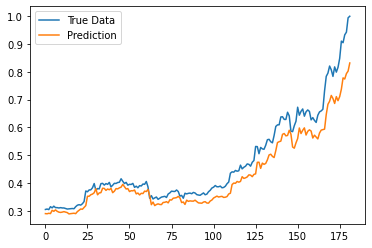

In [1776]:
plot_results(y_pred,y_test)

In [1777]:
y_pred_noscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [1778]:
y_test_unscaled

array([[ 9087.3 ],
       [ 9132.49],
       [ 9073.94],
       [ 9375.47],
       [ 9252.28],
       [ 9428.33],
       [ 9277.97],
       [ 9278.81],
       [ 9240.35],
       [ 9276.5 ],
       [ 9243.61],
       [ 9243.21],
       [ 9192.84],
       [ 9132.23],
       [ 9151.39],
       [ 9159.04],
       [ 9185.82],
       [ 9164.23],
       [ 9374.89],
       [ 9525.36],
       [ 9581.07],
       [ 9536.89],
       [ 9677.11],
       [ 9905.17],
       [10990.87],
       [10912.82],
       [11100.47],
       [11111.21],
       [11323.47],
       [11759.59],
       [11053.61],
       [11246.35],
       [11205.89],
       [11747.02],
       [11779.77],
       [11601.47],
       [11754.05],
       [11675.74],
       [11878.11],
       [11410.53],
       [11584.93],
       [11784.14],
       [11768.87],
       [11865.7 ],
       [11892.8 ],
       [12254.4 ],
       [11991.23],
       [11758.28],
       [11878.37],
       [11592.49],
       [11681.83],
       [11664.85],
       [1177

In [1779]:
y_pred_noscaled

array([[ 8661.311 ],
       [ 8643.807 ],
       [ 8695.043 ],
       [ 8663.974 ],
       [ 8999.194 ],
       [ 8897.684 ],
       [ 9042.652 ],
       [ 8898.602 ],
       [ 8811.894 ],
       [ 8782.62  ],
       [ 8814.644 ],
       [ 8864.585 ],
       [ 8820.116 ],
       [ 8764.914 ],
       [ 8629.324 ],
       [ 8657.153 ],
       [ 8672.969 ],
       [ 8699.5   ],
       [ 8659.329 ],
       [ 8866.142 ],
       [ 9002.392 ],
       [ 9138.201 ],
       [ 9108.871 ],
       [ 9301.978 ],
       [ 9486.343 ],
       [10449.668 ],
       [10449.472 ],
       [10606.476 ],
       [10674.484 ],
       [10809.7295],
       [11229.02  ],
       [10597.755 ],
       [10794.596 ],
       [10817.926 ],
       [11272.871 ],
       [11259.617 ],
       [11054.912 ],
       [11197.622 ],
       [11119.573 ],
       [11261.958 ],
       [10818.644 ],
       [10968.772 ],
       [11237.224 ],
       [11209.725 ],
       [11320.028 ],
       [11388.925 ],
       [11673.523 ],
       [11443

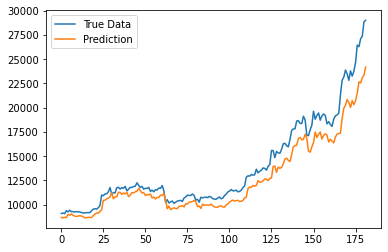

In [1780]:
plot_results(y_pred_noscaled,y_test_unscaled)

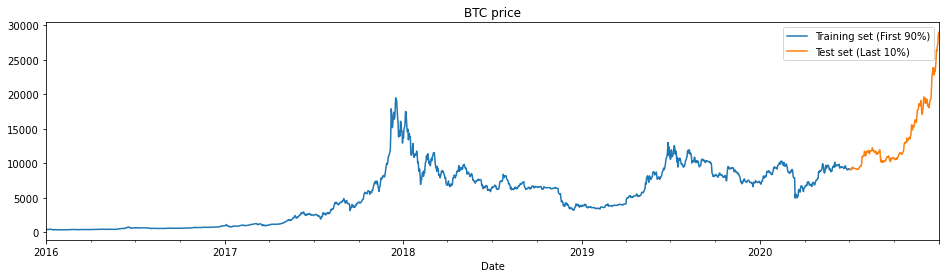

In [1781]:
df["BTC"].iloc[0:train_data_len].plot(figsize=(16,4),legend=True)
df["BTC"].iloc[train_data_len - n_past:].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('BTC price')
plt.show()

In [1782]:
df.head()

ETH     BTC       XRP   LTC       XLM  Palladium    Gold  \
Date                                                                        
2016-01-01  0.948024  434.33  0.005955  3.51  0.001748     562.00  1060.2   
2016-01-02  0.937124  433.44  0.006065  3.50  0.001741     562.00  1060.2   
2016-01-03  0.971905  430.01  0.006017  3.48  0.001744     562.00  1060.2   
2016-01-04  0.954480  433.09  0.005958  3.50  0.001748     544.20  1075.2   
2016-01-05  0.950176  431.96  0.006044  3.47  0.001721     535.75  1078.4   

                    HSI        N225   SP500  NVIDIA   AMD  
Date                                                       
2016-01-01  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-02  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-03  2810.900488  174.137258  2035.4   32.96  2.87  
2016-01-04  2735.571521  168.805923  2009.1   32.37  2.77  
2016-01-05  2717.819530  168.101637  2011.7   32.89  2.75

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            72192     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 122,161
Trainable params: 122,161
Non-trainable params: 0
________________________________________________

In [27]:
import shap

In [28]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [29]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, x_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test)
# init the JS visualization code
shap.initjs()

keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
explainer.expected_value

array([0.00524574], dtype=float32)

In [31]:
len(shap_values)

1

In [32]:
x_test.shape

(182, 1, 12)

In [33]:
shap_values[0].shape

(182, 1, 12)

In [34]:
shap_values[0][0].shape

(1, 12)

In [35]:
features = list(df.columns)

In [36]:
features

['ETH',
 'BTC',
 'XRP',
 'LTC',
 'XLM',
 'Palladium',
 'Gold',
 'HSI',
 'N225',
 'SP500',
 'NVIDIA',
 'AMD']

In [37]:
i=0
j=0

In [38]:
shap_values[0][i][j]

array([-6.29635649e-10,  1.40559476e-09,  2.21274909e-10, -1.00174549e-11,
        1.31391801e-11, -5.05363124e-11,  2.34130040e-10, -1.20770549e-10,
        1.15025814e-11,  4.63069954e-10,  2.67449389e-10, -2.50133128e-10])

In [39]:
x_test[i][j].shape

(12,)

In [50]:
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)
i = 0
j = 0
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], x_test_df)

In [41]:
shap.__version__

'0.40.0'

In [42]:
shap_values[0][0].shape

(1, 12)

In [43]:
i = 11
pred_i = model.predict(x_test[i:i+1])
sum_shap_i = shap_values[0][i].sum() + explainer.expected_value[0]

pred_i, sum_shap_i

(array([[0.00524573]], dtype=float32), 0.005245734246556338)

In [44]:
shap_values_2D = shap_values[0].reshape(-1,12)
x_test_2D = x_test.reshape(-1,12)


shap_values_2D.shape, x_test_2D.shape

((182, 12), (182, 12))

In [45]:
x_test_2d = pd.DataFrame(data=x_test_2D, columns = features)

In [46]:
x_test_2d.corr()

ETH       BTC       XRP       LTC       XLM  Palladium  \
ETH        1.000000  0.745839  0.640806  0.787880  0.632738   0.086986   
BTC        0.745839  1.000000  0.551086  0.788534  0.521494   0.165092   
XRP        0.640806  0.551086  1.000000  0.666524  0.706822   0.086281   
LTC        0.787880  0.788534  0.666524  1.000000  0.621059   0.139463   
XLM        0.632738  0.521494  0.706822  0.621059  1.000000   0.053008   
Palladium  0.086986  0.165092  0.086281  0.139463  0.053008   1.000000   
Gold       0.176858  0.263798  0.137382  0.196744 -0.001943   0.442256   
HSI       -0.025537  0.055873  0.055566  0.007282  0.050796   0.149327   
N225      -0.066237 -0.102185 -0.058613 -0.093688  0.019596   0.103763   
SP500      0.187402  0.199120  0.185746  0.193407  0.126841   0.019067   
NVIDIA     0.147909  0.169537  0.124726  0.157142  0.076461   0.055518   
AMD        0.141078  0.139150  0.131799  0.161665  0.113960   0.104825   

               Gold       HSI      N225     SP500    NVIDIA       AMD  
ETH        0.176858 -0.025537 -0.066237  0.187402  0.147909  0.141078  
BTC        0.263798  0.055873 -0.102185  0.199120  0.169537  0.139150  
XRP        0.137382  0.055566 -0.058613  0.185746  0.124726  0.131799  
LTC        0.196744  0.007282 -0.093688  0.193407  0.157142  0.161665  
XLM       -0.001943  0.050796  0.019596  0.126841  0.076461  0.113960  
Palladium  0.442256  0.149327  0.103763  0.019067  0.055518  0.104825  
Gold       1.000000  0.179099 -0.041389  0.087403  0.101819  0.049156  
HSI        0.179099  1.000000  0.425515  0.098044  0.030359 -0.051699  
N225      -0.041389  0.425515  1.000000  0.009607 -0.044269 -0.021312  
SP500      0.087403  0.098044  0.009607  1.000000  0.464698  0.328953  
NVIDIA     0.101819  0.030359 -0.044269  0.464698  1.000000  0.762252  
AMD        0.049156 -0.051699 -0.021312  0.328953  0.762252  1.000000

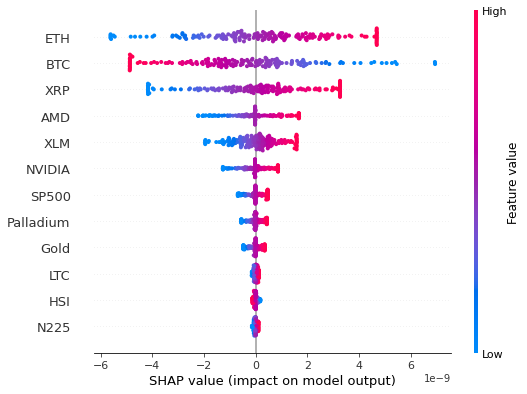

In [47]:
shap.summary_plot(shap_values_2D, x_test_2d)

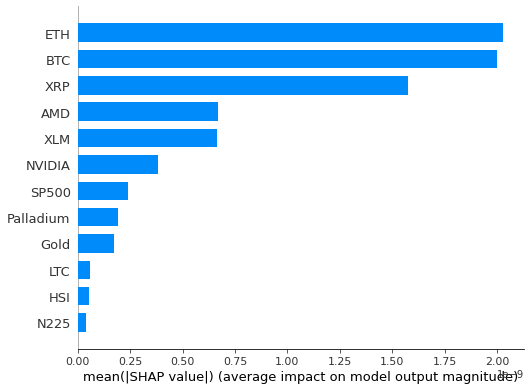

In [48]:
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")